# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from os.path import basename
from random import shuffle
from rouge_score import rouge_scorer
from statistics import mean, stdev

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('punkt')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/teo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsSummarisationModel:
    def __init__(self, stop_words_file, elim_stops, lemmatise, n_grams):
        self._ALPHA = 1
        self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
        self.elim_stops = elim_stops
        self.lemmatise = lemmatise
        self.n_grams = n_grams

        self.class_app = {
            True: 0,
            False: 0
        }
        self.class_words = {
            True: {},
            False: {}
        }
        self.total_words = {
            True: 0,
            False: 0
        }
        self.total_sents = 0
        self.voc = set()

        self.wnl = WordNetLemmatizer()
        self.nlp = load('en')

        self.stop_words = set(stopwords.words('english')) | set(' ')
        with open(stop_words_file) as f:
            self.stop_words.union(set(token.replace('\n', '') for token in f))


    def _remove_chars(self, s):
        for ch in self._chars_to_remove:
            s = s.replace(ch, '')
        return s


    def _should_keep_token(self, tok):
        return tok not in self.stop_words if self.elim_stops else True


    def group_n_grams(self, words):
        return ['|'.join(words[i : i + self.n_grams])
            for i in range(len(words) - self.n_grams + 1)]


    def parse_sents(self, sents):
        lems = []
        for sent in sents:
            tokens = word_tokenize(sent) if self.lemmatise else sent.split()
            for tok in tokens:
                if self._should_keep_token(tok):
                    if self.lemmatise:
                        lem = self.wnl.lemmatize(self._remove_chars(tok).lower())
                    else:
                        lem = tok

                    if lem and \
                        not self.elim_stops or lem not in self.stop_words:
                        lems.append(lem)

        return self.group_n_grams(lems)


    def _add_lems_to_class(self, lems, cl):
        for lem in lems:
            self.voc.add(lem)

            if lem in self.class_words[cl]:
                self.class_words[cl][lem] += 1
            else:
                self.class_words[cl][lem] = 1


    def add_file_summary(self, file, summ):
        with open(summ) as f:
            summ_str = f.read()
        with open(file) as f:
            file_sent = sent_tokenize(f.read())
            self.total_sents += len(file_sent)

        file_sent_keep = list(filter(lambda s: s in summ_str, file_sent))
        self.class_app[True] += len(file_sent_keep)

        summ_lems = self.parse_sents(file_sent_keep)
        self.total_words[True] += len(summ_lems)
        self._add_lems_to_class(summ_lems, True)

        file_sent_drop = list(filter(lambda s: s not in summ_str, file_sent))
        self.class_app[False] += len(file_sent_drop)

        drop_lems = self.parse_sents(file_sent_drop)
        self.total_words[False] += len(drop_lems)
        self._add_lems_to_class(drop_lems, False)


    def _compute_log_prob(self, word, cl):
        return log(
            (self.class_words[cl].get(word, 0) + self._ALPHA)
            / (self.total_words[cl] + len(self.voc) * self._ALPHA)
        )


    def _make_pred(self, sent):
        lems = self.parse_sents([sent])
        max_prob = -inf

        for cl in self.class_words:
            cl_prob = sum(
                map(lambda l: self._compute_log_prob(l, cl), lems),
                log(self.class_app[cl] / self.total_sents)
            )

            if max_prob < cl_prob:
                max_prob = cl_prob
                pred = cl

        return pred, max_prob


    def run_inference(self, file):
        with open(file) as f:
            sents = sent_tokenize(f.read())
        keeps = list(map(lambda s: self._make_pred(s), sents))
        predicted_sents = zip(sents, keeps)

        for pred, _ in keeps:
            if pred:
                return [sent for sent, keep in predicted_sents if keep[0]]

        predicted_sents = list(predicted_sents)
        predicted_sents.sort(key=lambda p: p[1][1])
        return [predicted_sents[0][0]]

In [3]:
def _get_files_summ(path):
    files = []
    for clss in listdir(f'{path}/News Articles'):
        files += list(map(
            lambda f: (
                f'{path}/News Articles/{clss}/{f}',
                f'{path}/Summaries/{clss}/{f}',
            ),
            listdir(f'{path}/News Articles/{clss}')
        ))

    shuffle(files)
    return files


def _get_train_test_files(path):
    files = _get_files_summ(path)
    num_files = len(files)
    num_tests = int(num_files / 4)

    test_files = files[:num_tests]
    train_files = files[num_tests:]

    return train_files, test_files, listdir(path)


def _run_tests(model, scorer, test_files, n_grams):
    recalls = {'rouge1': [], 'rouge2': []}
    precs = {'rouge1': [], 'rouge2': []}

    for file, summ in test_files:
        with open(summ) as f:
            true_summ = f.read()
        pred_summ = ' '.join(model.run_inference(file))
        scores = scorer.score(true_summ, pred_summ)

        for metric in recalls:
            recalls[metric].append(scores[metric].recall)
            precs[metric].append(scores[metric].precision)

    prec = {
        'rouge1': mean(precs['rouge1']),
        'rouge2': mean(precs['rouge2'])
    }
    rec = {
        'rouge1': mean(recalls['rouge1']),
        'rouge2': mean(recalls['rouge2'])
    }
    return rec, prec


def _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams):
    plt.figure(figsize=(23,5))
    plt.plot(xs, precs['rouge1'], label='Precizie ROUGE-1')
    plt.plot(xs, recalls['rouge1'], label='Regasire ROUGE-1')
    plt.plot(xs, precs['rouge2'], label='Precizie ROUGE-2')
    plt.plot(xs, recalls['rouge2'], label='Regasire ROUGE-2')
    
    plt.xlabel('Fisierele de antrenament', fontsize=20)
    plt.ylabel('Procentaj', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(fontsize=20)

    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'
    n_grams_str = 'monograme' if n_grams == 1 else 'bigrame'
    plt.title(
        f'Scoruri ROUGE, cu {n_grams_str}, {lem} lematizare si {elim} eliminarea cuvintelor neinformative',
        fontsize=20
    )

    plt.grid()
    plt.show()
    
    print(f'Precizia ROUGE-1 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {precs["rouge1"][len(precs["rouge1"]) - 1]}')
    print(f'Regasirea ROUGE-1 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {recalls["rouge1"][len(recalls["rouge2"]) - 1]}')
    print(f'Precizia ROUGE-2 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {precs["rouge2"][len(precs["rouge2"]) - 1]}')
    print(f'Regasirea ROUGE-2 cu {n_grams_str}, {lem} lematizare si {elim} eliminare: {recalls["rouge2"][len(recalls["rouge2"]) - 1]}')


def train_and_test(path, stop_words_file, elim_stops, lemmatise, n_grams):
    model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
    train_files, test_files, classes = _get_train_test_files(path)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], lemmatise)

    precs = {'rouge1': [], 'rouge2': []}
    recalls = {'rouge1': [], 'rouge2': []}
    xs = []
    i = 1

    for file, summ in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, scorer, test_files, n_grams)
            for metric in precs:
                precs[metric].append(prec[metric])
                recalls[metric].append(rec[metric])

        model.add_file_summary(file, summ)
        i += 1

    xs.append(i)
    rec, prec = _run_tests(model, scorer, test_files, n_grams)
    for metric in precs:
        precs[metric].append(prec[metric])
        recalls[metric].append(rec[metric])

    _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams)


def _get_file_groups(path, num_groups):
    files = _get_files_summ(path)

    num_files = len(files)
    chunk_size = int(num_files / num_groups)

    file_groups = [files[i*chunk_size : (i+1)*chunk_size]
        for i in range(num_groups)]

    return file_groups


def train_test_cross_validate(
    path,
    stop_words_file,
    elim_stops,
    lemmatise,
    n_grams,
    num_groups
):
    file_groups = _get_file_groups(path, num_groups)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], lemmatise)

    results = {
        'rouge1': {
            'precision': {},
            'recall': {}
        },
        'rouge2': {
            'precision': {},
            'recall': {}
        }
    }
    precs = {'rouge1': [], 'rouge2': []}
    recalls = {'rouge1': [], 'rouge2': []}

    for i in range(len(file_groups)):
        test_files = file_groups[i]
        train_groups = file_groups[:i] + file_groups[i+1:]
        train_files = sum(train_groups, [])

        model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
        [model.add_file_summary(file, summ) for file, summ in train_files]

        rec, prec = _run_tests(model, scorer, test_files, n_grams)
        for metric in precs:
            precs[metric].append(prec[metric])
            recalls[metric].append(rec[metric])

    for metric in results:
        results[metric]['precision']['mean'] = mean(precs[metric])
        results[metric]['recall']['mean'] = mean(recalls[metric])
        results[metric]['precision']['stddev'] = stdev(precs[metric])
        results[metric]['recall']['stddev'] = stdev(recalls[metric])

    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'
    n_grams_str = 'monograme' if n_grams == 1 else 'bigrame'
    print(f'Performantele modelului antrenat prin 5-fold cross validation cu {n_grams_str}, {lem} lematizare si {elim} eliminare')
    print(dumps(results, indent=4))

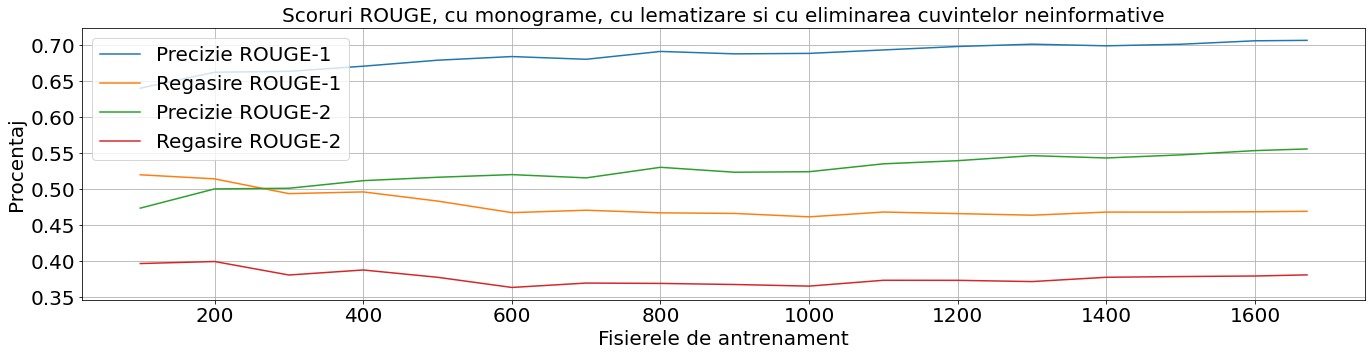

Precizia ROUGE-1 cu monograme, cu lematizare si cu eliminare: 0.7069817255570273
Regasirea ROUGE-1 cu monograme, cu lematizare si cu eliminare: 0.4693967343062877
Precizia ROUGE-2 cu monograme, cu lematizare si cu eliminare: 0.5560637228961481
Regasirea ROUGE-2 cu monograme, cu lematizare si cu eliminare: 0.3810622122452891


In [4]:
train_and_test('BBC News Summary', 'stop_words', True, True, 1)

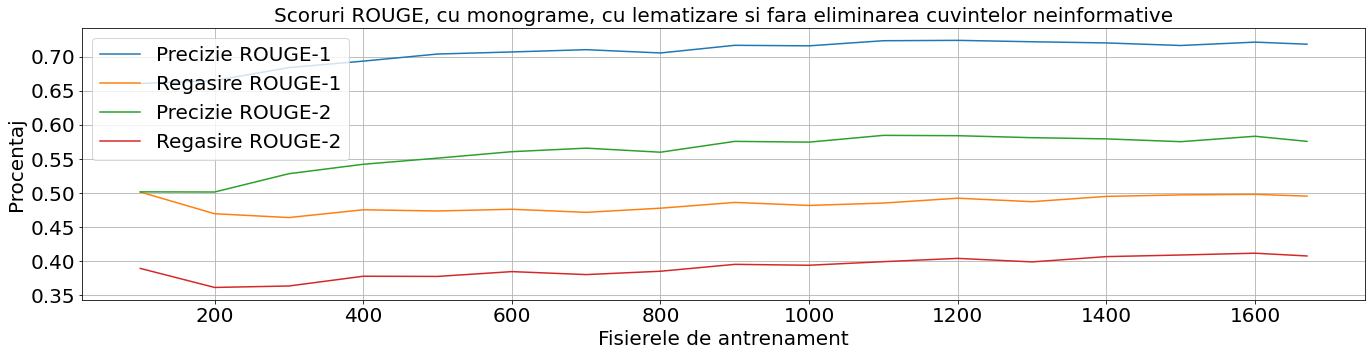

Precizia ROUGE-1 cu monograme, cu lematizare si fara eliminare: 0.7182312697185397
Regasirea ROUGE-1 cu monograme, cu lematizare si fara eliminare: 0.4952752953017797
Precizia ROUGE-2 cu monograme, cu lematizare si fara eliminare: 0.5756249314548333
Regasirea ROUGE-2 cu monograme, cu lematizare si fara eliminare: 0.40743376396128217


In [5]:
train_and_test('BBC News Summary', 'stop_words', False, True, 1)

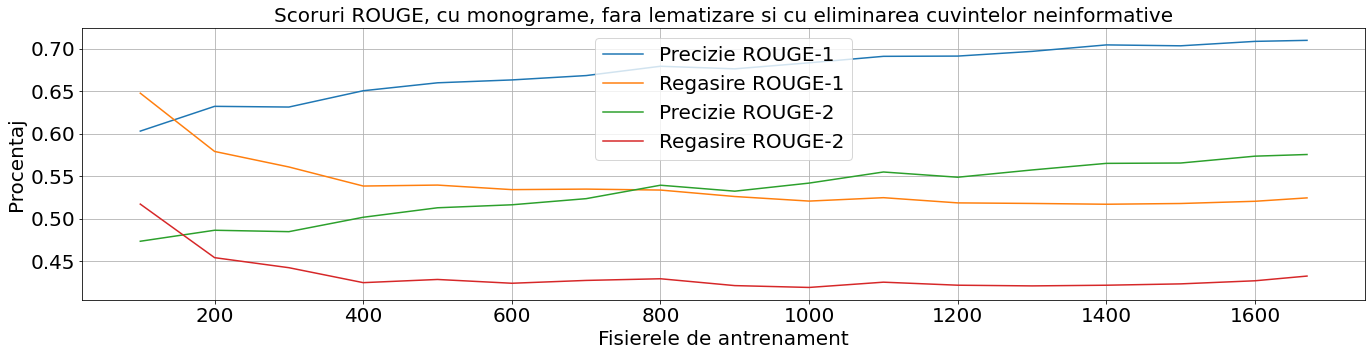

Precizia ROUGE-1 cu monograme, fara lematizare si cu eliminare: 0.7095996701756162
Regasirea ROUGE-1 cu monograme, fara lematizare si cu eliminare: 0.5244933063430639
Precizia ROUGE-2 cu monograme, fara lematizare si cu eliminare: 0.5754699869625461
Regasirea ROUGE-2 cu monograme, fara lematizare si cu eliminare: 0.4326289367112205


In [6]:
train_and_test('BBC News Summary', 'stop_words', True, False, 1)

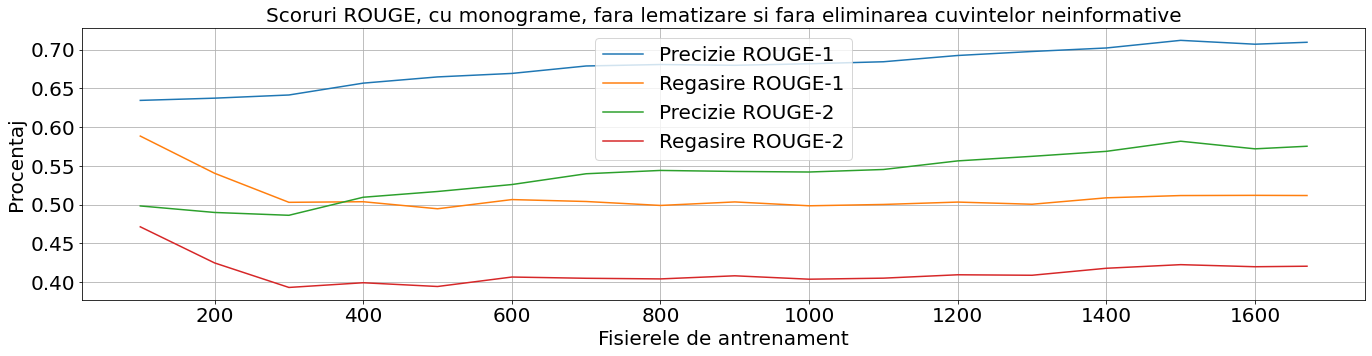

Precizia ROUGE-1 cu monograme, fara lematizare si fara eliminare: 0.7095567743406925
Regasirea ROUGE-1 cu monograme, fara lematizare si fara eliminare: 0.5118260710846282
Precizia ROUGE-2 cu monograme, fara lematizare si fara eliminare: 0.5754086048643172
Regasirea ROUGE-2 cu monograme, fara lematizare si fara eliminare: 0.42060573229359804


In [7]:
train_and_test('BBC News Summary', 'stop_words', False, False, 1)

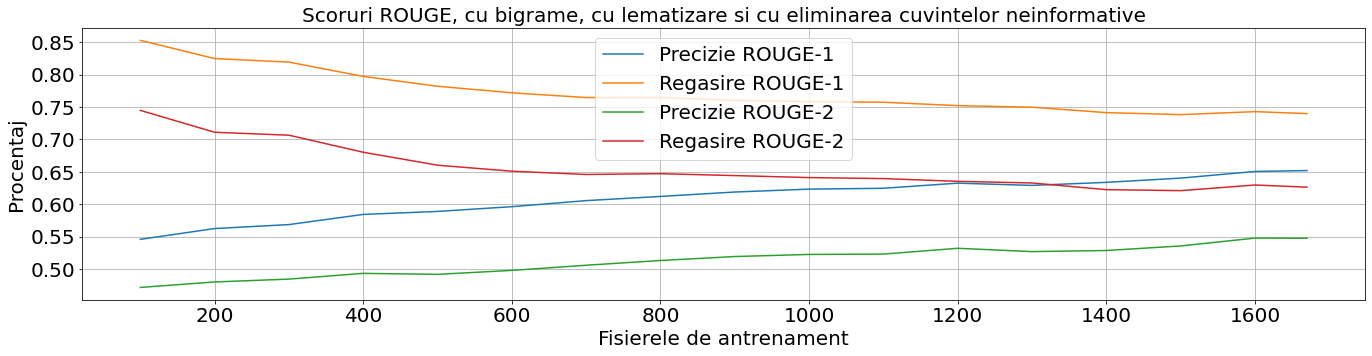

Precizia ROUGE-1 cu bigrame, cu lematizare si cu eliminare: 0.6520255942125209
Regasirea ROUGE-1 cu bigrame, cu lematizare si cu eliminare: 0.7398268654895337
Precizia ROUGE-2 cu bigrame, cu lematizare si cu eliminare: 0.5477437463405666
Regasirea ROUGE-2 cu bigrame, cu lematizare si cu eliminare: 0.6264412424120052


In [8]:
train_and_test('BBC News Summary', 'stop_words', True, True, 2)

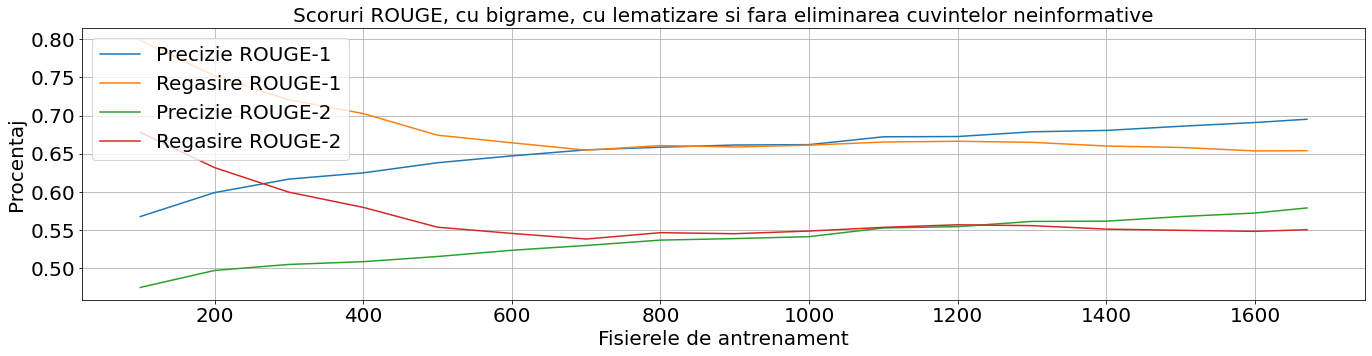

Precizia ROUGE-1 cu bigrame, cu lematizare si fara eliminare: 0.6952036350932663
Regasirea ROUGE-1 cu bigrame, cu lematizare si fara eliminare: 0.6540670939727257
Precizia ROUGE-2 cu bigrame, cu lematizare si fara eliminare: 0.5791233837207655
Regasirea ROUGE-2 cu bigrame, cu lematizare si fara eliminare: 0.5506230951522566


In [9]:
train_and_test('BBC News Summary', 'stop_words', False, True, 2)

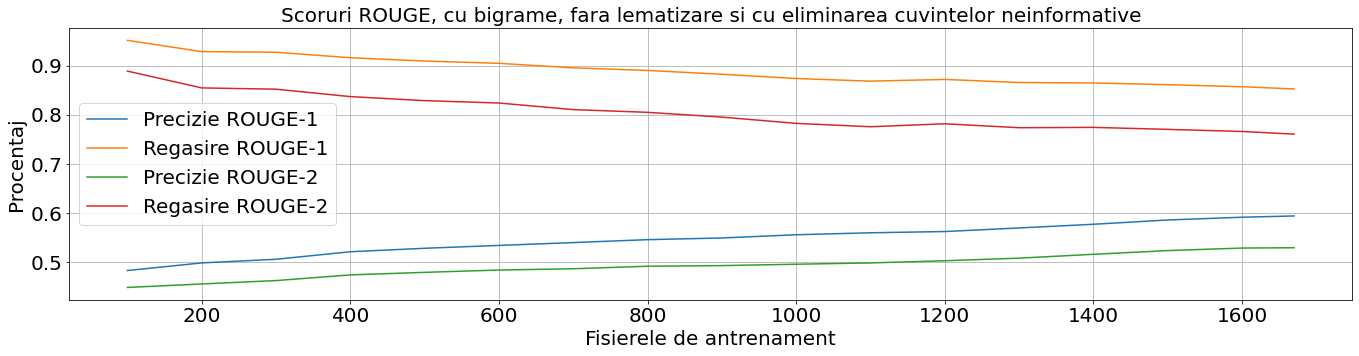

Precizia ROUGE-1 cu bigrame, fara lematizare si cu eliminare: 0.5940254966579379
Regasirea ROUGE-1 cu bigrame, fara lematizare si cu eliminare: 0.852500801053652
Precizia ROUGE-2 cu bigrame, fara lematizare si cu eliminare: 0.5293236002619114
Regasirea ROUGE-2 cu bigrame, fara lematizare si cu eliminare: 0.7605596119765627


In [10]:
train_and_test('BBC News Summary', 'stop_words', True, False, 2)

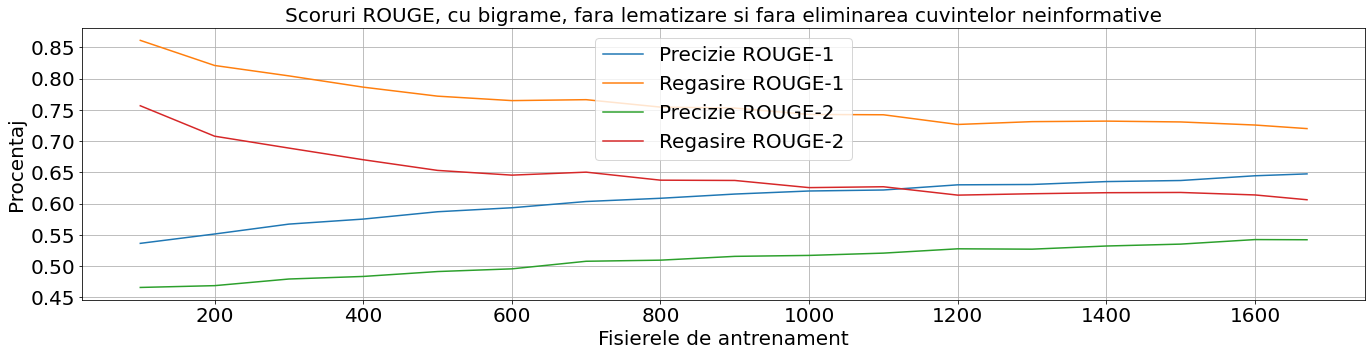

Precizia ROUGE-1 cu bigrame, fara lematizare si fara eliminare: 0.647477656951262
Regasirea ROUGE-1 cu bigrame, fara lematizare si fara eliminare: 0.7199358649868726
Precizia ROUGE-2 cu bigrame, fara lematizare si fara eliminare: 0.5421193219631815
Regasirea ROUGE-2 cu bigrame, fara lematizare si fara eliminare: 0.6061184631630818


In [11]:
train_and_test('BBC News Summary', 'stop_words', False, False, 2)

In [12]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, cu lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7050464843400697,
            "stddev": 0.010132848364320182
        },
        "recall": {
            "mean": 0.4769473541299676,
            "stddev": 0.011477879648964587
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5589936858354606,
            "stddev": 0.011077032997675429
        },
        "recall": {
            "mean": 0.38785603956665127,
            "stddev": 0.01196233678925679
        }
    }
}


In [13]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, cu lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7110093883178418,
            "stddev": 0.0056438422908972295
        },
        "recall": {
            "mean": 0.4997622241183337,
            "stddev": 0.009922674001164897
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5730194359444083,
            "stddev": 0.008011942101222426
        },
        "recall": {
            "mean": 0.41049363564848407,
            "stddev": 0.010058585260870485
        }
    }
}


In [14]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, fara lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7008598502628662,
            "stddev": 0.009400513374860007
        },
        "recall": {
            "mean": 0.5197547203660784,
            "stddev": 0.016336551190292453
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5641151912589718,
            "stddev": 0.013160533395517857
        },
        "recall": {
            "mean": 0.4272934152790735,
            "stddev": 0.01729643410226378
        }
    }
}


In [15]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 1, 5)

Performantele modelului antrenat prin 5-fold cross validation cu monograme, fara lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.7101537893275669,
            "stddev": 0.008459510566353702
        },
        "recall": {
            "mean": 0.5145467557742113,
            "stddev": 0.020828126076294265
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5798338659319365,
            "stddev": 0.008687273282721798
        },
        "recall": {
            "mean": 0.427170805214521,
            "stddev": 0.018476540458942304
        }
    }
}


In [16]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, cu lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6515118126601541,
            "stddev": 0.009094185339670562
        },
        "recall": {
            "mean": 0.7324994974675925,
            "stddev": 0.01451753592873669
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5473728502187658,
            "stddev": 0.013227512763615517
        },
        "recall": {
            "mean": 0.6202986343000166,
            "stddev": 0.01751898683737953
        }
    }
}


In [17]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, cu lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6841052123421194,
            "stddev": 0.006226431313938488
        },
        "recall": {
            "mean": 0.659032428675646,
            "stddev": 0.008357036082668513
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5633588330632865,
            "stddev": 0.006783159724625336
        },
        "recall": {
            "mean": 0.5494986648931789,
            "stddev": 0.006250935655469751
        }
    }
}


In [18]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, fara lematizare si cu eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.5888603198011629,
            "stddev": 0.00569345568580389
        },
        "recall": {
            "mean": 0.8585907649675695,
            "stddev": 0.007128966434439457
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5259735995652276,
            "stddev": 0.005497453662127213
        },
        "recall": {
            "mean": 0.7677305851680398,
            "stddev": 0.0086435371218913
        }
    }
}


In [19]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 2, 5)

Performantele modelului antrenat prin 5-fold cross validation cu bigrame, fara lematizare si fara eliminare
{
    "rouge1": {
        "precision": {
            "mean": 0.6559741519731428,
            "stddev": 0.009807975988461585
        },
        "recall": {
            "mean": 0.7236159347132108,
            "stddev": 0.007941321348031802
        }
    },
    "rouge2": {
        "precision": {
            "mean": 0.5529162776562577,
            "stddev": 0.012606053283321253
        },
        "recall": {
            "mean": 0.6141111811819507,
            "stddev": 0.00781923622528978
        }
    }
}
